### Ajuste de parámetros mediante validación cruzada

Imports:

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from time import time
import shutil

Carga de datos, MNIST:

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [ ]:
mean_img = train_images.mean(axis=0)
train_images = train_images - mean_img
test_images = test_images - mean_img

Reduzco mucho el tamaño del conjunto de entrenamiento, para que las pruebas vayan más rápido:

In [ ]:
# Numero de ejemplos para entrenamiento
num_train = 5000

# Seleccionamos imagenes para training
tr_images = train_images[:num_train]
tr_labels = train_labels[:num_train]
print(tr_images.shape)
print(tr_labels.shape)

(5000, 28, 28)
(5000,)


Validación de un modelo:

Usamos la clase ``StratifiedKFold`` (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) de ``scikitlearn``, que genera índices para entrenamiento y validación de acuerdo a una estrategia de validación cruzada con k folds.

En el siguiente ejemplo se usa ``k = 5``:


In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)
# kfold.split(...) devuelve un generador que genera los índices de entrenamiento
# y test para cada una de las particiones

cvscores = []
for itrain, itest in kfold.split(tr_images, tr_labels):
    # Creamos el modelo:
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(1.0)))
    model.add(keras.layers.Dense(10, activation="softmax"))

    # Lo compilamos:
    model.compile(optimizer=keras.optimizers.Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

    # Lo entrenamos:
    nepochs = 30
    history = model.fit(tr_images[itrain],
                        tr_labels[itrain],
                        epochs=nepochs,
                        verbose=0,
                        batch_size=50)

    # Lo evaluamos:
    loss, acc = model.evaluate(tr_images[itest], tr_labels[itest], verbose=0)

    print("Accuracy: %.2f%%" % (acc*100.0))
    cvscores.append(acc * 100.)
print("%.2f%% \u00B1 %.2f%%" % (np.mean(cvscores), np.std(cvscores)))

Accuracy: 89.90%
Accuracy: 90.70%
Accuracy: 91.90%
Accuracy: 88.00%
Accuracy: 87.80%
89.66% ± 1.57%


A continuación definimos algunas funciones para simplificar la tarea.

Esta función crea una red neuronal con ``nhidden`` neuronas ocultas y constante de regularización ``lreg``:

In [ ]:
def create_model(nhidden, lreg):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(nhidden, activation="relu", kernel_regularizer=keras.regularizers.l2(lreg)))
    model.add(keras.layers.Dense(10, activation="softmax"))

    return model

Esta función evalúa un modelo haciendo validación cruzada:

In [ ]:
def xvalidation(x, y, nhidden, lreg, lrate, num_epochs, bsize, nfolds, semilla):

    kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=semilla)
    cvscores = np.zeros(nfolds)
    for i, (train, test) in enumerate(kfold.split(x, y)):
        model = create_model(nhidden, lreg)
        model.compile(optimizer=keras.optimizers.Adam(lrate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['acc'])

        history = model.fit(x[train],
                            y[train],
                            epochs=num_epochs,
                            verbose=0,
                            batch_size=bsize)

        loss, acc = model.evaluate(x[test], y[test], verbose=0)

        cvscores[i] = acc
    return cvscores

En la función anterior, ¿por qué se crea el ``StratifiedKFold`` pasando como argumento ``random_state=semilla``?

Búsqueda del número de neuronas y la constante de regularización:

In [ ]:
for nhidden in [32, 64]:
  for lreg in [1.0, 0.1, 0.01, 0.001]:
      cvscores = xvalidation(tr_images, tr_labels, nhidden, lreg, 0.001, 30, 50, 5, 13)
      print("nhidden = %d" % (nhidden))
      print("lreg = %f" % (lreg))
      print(cvscores)
      print("   %.2f%% \u00B1 %.2f%%" % (100*np.mean(cvscores), 100*np.std(cvscores)))

nhidden = 32
lreg = 1.000000
[0.89399999 0.88200003 0.88499999 0.89899999 0.90200001]
   89.24% ± 0.78%
nhidden = 32
lreg = 0.100000
[0.90200001 0.90700001 0.88499999 0.91600001 0.898     ]
   90.16% ± 1.02%
nhidden = 32
lreg = 0.010000
[0.90799999 0.90600002 0.88099998 0.91000003 0.88700002]
   89.84% ± 1.20%
nhidden = 32
lreg = 0.001000
[0.89899999 0.90100002 0.88800001 0.90799999 0.90899998]
   90.10% ± 0.76%
nhidden = 64
lreg = 1.000000
[0.91000003 0.903      0.90499997 0.89899999 0.89700001]
   90.28% ± 0.46%
nhidden = 64
lreg = 0.100000
[0.926      0.91500002 0.90899998 0.92000002 0.926     ]
   91.92% ± 0.66%
nhidden = 64
lreg = 0.010000
[0.935      0.92299998 0.91900003 0.92799997 0.921     ]
   92.52% ± 0.57%
nhidden = 64
lreg = 0.001000
[0.90799999 0.91600001 0.90700001 0.92000002 0.91500002]
   91.32% ± 0.50%


Elegimos los mejores parámetros de acuerdo a la búsqueda anterior y volvemos a entrenar el modelo con esos parámetros usando todos los datos de entrenamiento:

In [ ]:
nhidden = 64
lreg = 0.01

model = create_model(nhidden, lreg)

model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(tr_images,
                    tr_labels,
                    epochs=30,
                    verbose=0,
                    batch_size=50)

Y lo aplicamos a los datos de test:

In [ ]:
loss, acc = model.evaluate(test_images, test_labels, verbose=0)
print(acc)

0.9192000031471252


**Otras métricas:** ¿Cómo calcular, por ejemplo el ROC-AUC?

Como ejemplo, calculemos la ROC para una de las clases frente al resto:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


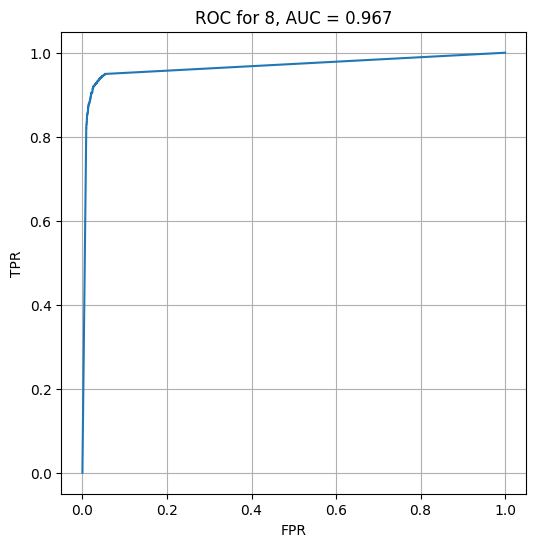

In [ ]:
from sklearn import metrics

target = 8
probs = model.predict(test_images)
prob_target = probs[:, target]
ytrue = test_labels == target

fpr, tpr, thresholds = metrics.roc_curve(ytrue, prob_target, pos_label=1)
auc = metrics.roc_auc_score(ytrue, prob_target)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC for {target}, AUC = {auc:.3f}')
plt.grid(True)
plt.show()

**Ejercicio:** Realizar una validación cruzada utilizando una métrica de evaluación distinta.

Cómo hacer todo esto de una manera más automática:

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) de ``scikit-learn``.

- Keras Tuner: https://www.tensorflow.org/tutorials/keras/keras_tuner

- HParams dashboard en tensorboard: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

### Ejemplo de uso de GridSearchCV:

Usamos ``scikeras``, un wrapper de keras para ``scikit-learn``.

In [ ]:
!pip install -U scikeras scikit-learn

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

Función para crear el modelo. Devuelve el modelo ya compilado:

In [ ]:
def create_model(nhidden, lreg, lrate):
    model = keras.Sequential()
    model.add(keras.layers.Input((28, 28)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(nhidden, activation="relu", kernel_regularizer=keras.regularizers.l2(lreg)))
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(lrate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

    return model

Usamos la clase [KerasClassifier](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier) para adaptar el modelo al estilo de ``scikit-learn``:

In [ ]:
model = KerasClassifier(model=create_model, lreg=1.0, nhidden=50, lrate=0.001)

Ahora podemos usar los métodos típicos de ``scikit-learn``, como ``fit``, ``predict``, ``predict_proba``, ``score``, etc. Por ejemplo:

In [ ]:
model.fit(tr_images, tr_labels, epochs=10, batch_size=50)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.5510 - loss: 114.7266
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8946 - loss: 37.6045
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9311 - loss: 22.4490
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9307 - loss: 14.2437
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9366 - loss: 9.3823
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9541 - loss: 6.0829
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9385 - loss: 4.3786
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9321 - loss: 3.5889
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9397 - loss: 3.0350
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.9294 - loss: 2.6357


,model,<function cre...x7a40a093f100>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,None
,validation_batch_size,None
,verbose,1
,callbacks,None


In [ ]:
preds = model.predict(tr_images)
print(preds[:10])
probs = model.predict_proba(tr_images)
print(probs[:10])
score = model.score(tr_images, tr_labels)
print(score)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[5 0 4 1 9 2 1 3 1 4]
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[3.12477620e-29 0.00000000e+00 2.39771136e-24 5.86254170e-11
  0.00000000e+00 9.99999940e-01 5.28889647e-18 0.00000000e+00
  1.51300409e-29 4.43210273e-34]
 [9.99999940e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.01757629e-37 1.79294318e-07 7.01650516e-14
  9.99999702e-01 1.24879907e-16 2.17367325e-26 3.33721737e-18
  1.55838684e-33 1.20827490e-22]
 [2.52053169e-28 9.99999940e-01 1.68645066e-20 6.75367885e-30
  3.27871762e-26 5.47540456e-33 1.44299852e-35 2.05789725e-20
  8.26626951e-21 3.59910528e-30]
 [0.00000000e+00 1.29249364e-21 0.00000000e+00 0.00000000e+00
  1.63333161e-18 4.99324860e-35 0.00000000e+00 1.02406522e-16
  6.31357198e-36 9.99999940e-01]
 [2.75692398e-35 1.62108882e-28 9.99999940e-01 1.05427709e-17
  4.87479000e-35 1.70069505e-21 6.43919818e-22 1.

Y también podemos usar el modelo en un ``GridSearchCV``:

In [ ]:
parameters = {'nhidden': [32, 64], 'lreg': [1.0, 0.1, 0.01, 0.001], 'lrate': [0.001]}
model = KerasClassifier(model=create_model, lreg=1.0, nhidden=50, lrate=0.001)

gscv = GridSearchCV(estimator=model, param_grid=parameters, cv=5, scoring='accuracy')
fitted_models = gscv.fit(tr_images, tr_labels, epochs=30, batch_size=50, verbose=0)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━

Resumen y mejores parámetros:

In [ ]:
print("Best: %f using %s" % (fitted_models.best_score_, fitted_models.best_params_))
for params, mean_score, std_score in zip(fitted_models.cv_results_['params'], fitted_models.cv_results_['mean_test_score'], fitted_models.cv_results_['std_test_score']):
    print("%f \u00B1 %f with: %r" % (mean_score, std_score, params))

Best: 0.909200 using {'lrate': 0.001, 'lreg': 0.01, 'nhidden': 64}
0.887600 ± 0.011775 with: {'lrate': 0.001, 'lreg': 1.0, 'nhidden': 32}
0.881800 ± 0.017452 with: {'lrate': 0.001, 'lreg': 1.0, 'nhidden': 64}
0.901400 ± 0.008040 with: {'lrate': 0.001, 'lreg': 0.1, 'nhidden': 32}
0.903000 ± 0.009654 with: {'lrate': 0.001, 'lreg': 0.1, 'nhidden': 64}
0.893600 ± 0.008163 with: {'lrate': 0.001, 'lreg': 0.01, 'nhidden': 32}
0.909200 ± 0.015105 with: {'lrate': 0.001, 'lreg': 0.01, 'nhidden': 64}
0.891400 ± 0.009646 with: {'lrate': 0.001, 'lreg': 0.001, 'nhidden': 32}
0.906800 ± 0.011179 with: {'lrate': 0.001, 'lreg': 0.001, 'nhidden': 64}


### Apéndice: checkpointing y early stopping en Keras.

``ModelCheckpoint``: https://keras.io/api/callbacks/model_checkpoint/

Es un callback que sirve para salvar un modelo de Keras durante el entrenamiento, cada cierto número de épocas.

In [ ]:
# Modelo:
model = keras.Sequential()
model.add(keras.layers.Input((28, 28)))
model.add(keras.layers.Flatten(name="entrada"))
model.add(keras.layers.Dense(64, activation="relu", name="oculta"))
model.add(keras.layers.Dense(10, activation="softmax", name="salida"))

# Compile:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Callback a TensorBoard:
cb1 = keras.callbacks.TensorBoard(log_dir='logs/prueba', histogram_freq=1, write_images=True)
checkpoint_filepath = 'logs/checkpoint.model.{epoch:02d}-{val_loss:.2f}.keras'
cb2 = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss")
callbacks = [cb1, cb2]

# Entrenamiento del modelo:
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    validation_data=(test_images, test_labels),
                    batch_size=50,
                    callbacks=callbacks)

Epoch 1/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.8493 - loss: 7.5166 - val_acc: 0.9355 - val_loss: 1.6020
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - acc: 0.9466 - loss: 1.0720 - val_acc: 0.9433 - val_loss: 1.1449
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.9598 - loss: 0.5747 - val_acc: 0.9456 - val_loss: 0.8535
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.9654 - loss: 0.3951 - val_acc: 0.9538 - val_loss: 0.6834
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9697 - loss: 0.3001 - val_acc: 0.9548 - val_loss: 0.6621
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9747 - loss: 0.2191 - val_acc: 0.9504 - val_loss: 0.7035
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - acc: 0.9758 - loss: 0.1802 - val_acc: 0.9564 - val_loss: 0.5755
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.9778 - loss: 0.1581 - val_acc: 0.9557 - val_loss: 0.6091
Epoch 9/20
1200/1200 ━━━━━━━━━━━━━━━━━━

In [ ]:
loaded_model = keras.models.load_model('logs/checkpoint.model.18-0.51.keras')
loaded_model.summary()
loss_test, acc_test = loaded_model.evaluate(test_images, test_labels)
print("Loss on test set = %f" % (loss_test))
print("Accuracy on test set = %f" % (acc_test))

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oculta (Dense)                  │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ salida (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,892 (198.80 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc: 0.9572 - loss: 0.6168
Loss on test set = 0.509630
Accuracy on test set = 0.963600


``EarlyStopping``: https://keras.io/api/callbacks/early_stopping/

Es un callback que sirve para interrumpir el entrenamiento cuando la métrica observada deja de mejorar.


In [ ]:
# Modelo:
model = keras.Sequential()
model.add(keras.layers.Input((28, 28)))
model.add(keras.layers.Flatten(name="entrada"))
model.add(keras.layers.Dense(64, activation="relu", name="oculta"))
model.add(keras.layers.Dense(10, activation="softmax", name="salida"))

# Compile:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Callback a TensorBoard:
cb1 = keras.callbacks.TensorBoard(log_dir='logs/prueba', histogram_freq=1, write_images=True)
cb2 = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=2)
callbacks = [cb1, cb2]

# Entrenamiento del modelo:
history = model.fit(train_images,
                    train_labels,
                    epochs=100,
                    validation_data=(test_images, test_labels),
                    batch_size=50,
                    callbacks=callbacks)

Epoch 1/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.8450 - loss: 7.9507 - val_acc: 0.9365 - val_loss: 1.6174
Epoch 2/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9447 - loss: 1.1549 - val_acc: 0.9452 - val_loss: 1.0785
Epoch 3/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9597 - loss: 0.5821 - val_acc: 0.9478 - val_loss: 0.9201
Epoch 4/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.9655 - loss: 0.3906 - val_acc: 0.9545 - val_loss: 0.6999
Epoch 5/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9720 - loss: 0.2822 - val_acc: 0.9529 - val_loss: 0.6904
Epoch 6/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - acc: 0.9748 - loss: 0.2186 - val_acc: 0.9472 - val_loss: 0.7030


### Otras librerías para optimización de hiperparámetros

- [Optuna](https://optuna.org/)
- [Hyperopt](http://hyperopt.github.io/hyperopt/)
- [Ray Tune](https://docs.ray.io/en/latest/tune/index.html)